In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    # Convert each element in omega to shifted_omega
    shifted_omega = [(arr + 90.0) % 360.0 - 90.0 for arr in omega]
    
    # Convert to cis/trans (0 = cis, 1 = trans) using np.where
    cistrans = [np.where(arr > 90.0, 1, 0).astype(int) for arr in shifted_omega]
    return cistrans


In [4]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    var = x.var()  # Variance for normalization
    g = np.correlate((x-mu), (x-mu), mode='full')[tau-1:]
    g = g / var
    n = np.arange(tau,0,-1)
    return g/n

In [5]:
def multi_autocorr(x_list, max_tau=None):
    """Given a list of 1D trajectories x (each could be different lengths), compute an autocorrelation.
    INPUTS
    x_list  - a list of np.array objects. Each could be different lengths.

    PARAMETERS
    max_tau - the maximum frame to compute the autocorrelation.  If None, use the whole range. Default: None.
    """

    from tqdm import tqdm
    import numpy as np

    ntraj = len(x_list)
    x = np.concatenate(x_list)
    mu = x.mean(axis=0)
    var = x.var(axis=0)

    max_trajlength = max([x_list[i].shape[0] for i in range(ntraj)])
    print('max_trajlength', max_trajlength)
    
    if max_tau is None:
        max_tau = max_trajlength
        
    elif max_tau > max_trajlength:
        print("Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength") 
        max_tau = max_trajlength
        
    result = np.zeros(max_tau)
    n = np.zeros((max_tau,))
        
    with tqdm(range(ntraj), desc="Processing trajectories", leave=True) as pbar:
        for i in pbar:
            this_tau = x_list[i].shape[0]
            
            if this_tau > max_tau:
                T = 2 * this_tau - 1
                result[0:max_tau] += np.correlate((x_list[i] - mu), (x_list[i] - mu), mode='full')[this_tau-1:this_tau-1+max_tau]
                n[0:max_tau] += np.arange(this_tau, 0, -1)[0:max_tau]
            else:
                result[0:this_tau] += np.correlate((x_list[i] - mu), (x_list[i] - mu), mode='full')[this_tau-1:]
                n[0:this_tau] += np.arange(this_tau, 0, -1)
                
    result = result / var
    return result / n

## Load the data

In [6]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array

print(len(all_omega)) 

all_omega[0]

842


array([[   0.83861196,  -14.872943  ,    7.2696185 ],
       [ -15.203701  ,   20.326454  ,  -13.589486  ],
       [ -22.909151  ,   31.408817  ,    5.943763  ],
       ...,
       [-174.01523   , -159.77078   ,    6.4231105 ],
       [-165.69098   ,  177.86435   ,    5.978243  ],
       [-155.33615   , -168.63237   ,   34.37562   ]], dtype=float32)

In [7]:
# This a list of 742 (N_i, 3) np.arrays, where N_i is the size of the i^{th} trajectory
all_cistrans = omega2cistrans(all_omega)

all_cistrans[0].shape
all_cistrans[0]


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]])

## Compute average and stddev over the 0=cis/1=trans trajectories 

In [8]:
# This a list of 742 (N_i, 3) np.arrays, where N_i is the size of the i^{th} trajectory
ntraj = len(all_cistrans)

# convert to floats for downstream operations
for i in range(ntraj):
    all_cistrans[i] = all_cistrans[i].astype(float)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
minlength = min( [ len(all_cistrans[i]) for i in range(ntraj) ])
ns_per_step = 0.01 # 10 ps 
print(f'minlength = {minlength} snapshots ({minlength*ns_per_step:.3f} ns)')
print(f'maxlength = {maxlength} snapshots ({maxlength*ns_per_step:.3f} ns)')

# Make an array to store all the trajectories
arr_cistrans = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    arr_cistrans[i, 0:n, :] = all_cistrans[i]

arr_cistrans.shape

minlength = 4001 snapshots (40.010 ns)
maxlength = 492298 snapshots (4922.980 ns)


(842, 492298, 3)

## Autocoorelation Plot

In [9]:
ntraj = len(all_cistrans)
all_cistrans_res0 = [ all_cistrans[i][:,0] for i in range(ntraj) ]
all_cistrans_res1 = [ all_cistrans[i][:,1] for i in range(ntraj) ]
all_cistrans_res2 = [ all_cistrans[i][:,2] for i in range(ntraj) ]

max_tau = 500000
stride = 100
result_res0 = multi_autocorr(all_cistrans_res0[0::stride], max_tau=max_tau)
result_res1 = multi_autocorr(all_cistrans_res1[0::stride], max_tau=max_tau)
result_res2 = multi_autocorr(all_cistrans_res2[0::stride], max_tau=max_tau)

Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]


Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]


Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]


In [10]:
result_res0.shape

(350495,)

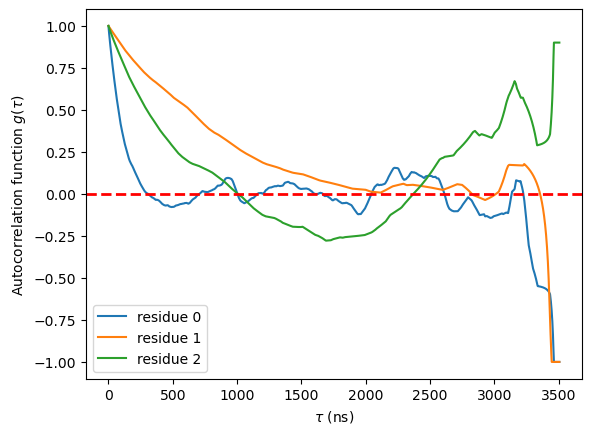

In [14]:
ns_per_step = 0.01
max_tau_res0 = result_res0.shape[0]
max_tau_res1 = result_res1.shape[0]
max_tau_res2 = result_res2.shape[0]

plt.figure()
plt.plot(np.arange(max_tau_res0)*ns_per_step, result_res0, label='residue 0')
plt.plot(np.arange(max_tau_res1)*ns_per_step, result_res1, label='residue 1')
plt.plot(np.arange(max_tau_res2)*ns_per_step, result_res2, label='residue 2')
plt.axhline(y=0.0, color='r', linestyle='--', linewidth=2)
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'Autocorrelation function $g(\tau)$')
plt.legend(loc='best')

plt.savefig('autocorrel_res012_5us.pdf')

In [15]:
# Save the autocorrel functions!
Data_autocorrel = Data([result_res0, result_res1, result_res2])
Data_autocorrel.save('autocoorel_data/autocorrel_res012_5us_100stride.pkl')

In [8]:
# Make five partitions of the trajectories at random
ntraj = len(all_cistrans)
ntrials = 5


Ind = np.random.permutation(np.arange(ntraj)).astype(int)
nchunk =  int(ntraj/ntrials)  # the number of trajs in each trial

Ind_trials = [ Ind[(i*nchunk) : ((i+1)*nchunk)].astype(int) for i in range(ntrials)]
all_cistrans_trials = []
for trial in range(ntrials):
    all_cistrans_trials.append( [all_cistrans[i] for i in Ind_trials[trial]] )

if ntraj > nchunk*ntrials:
    # add the remaining trajs to the first group
    for i in range(nchunk*ntrials, ntraj):
        all_cistrans_trials[0].append( all_cistrans[i] )

## Calculate multi_autocorr for each resiue, for each trial

for trial in range(ntrials):

    ntraj_this_trial = len(all_cistrans_trials[trial])
    all_cistrans_res0 = [ all_cistrans_trials[trial][i][:,0] for i in range(ntraj_this_trial) ]
    all_cistrans_res1 = [ all_cistrans_trials[trial][i][:,1] for i in range(ntraj_this_trial) ]
    all_cistrans_res2 = [ all_cistrans_trials[trial][i][:,2] for i in range(ntraj_this_trial) ]
    
    max_tau = 500000
    stride = 100
    result_res0 = multi_autocorr(all_cistrans_res0[0::stride], max_tau=max_tau)
    result_res1 = multi_autocorr(all_cistrans_res1[0::stride], max_tau=max_tau)
    result_res2 = multi_autocorr(all_cistrans_res2[0::stride], max_tau=max_tau)

    # Save the autocorrel functions!
    Data_autocorrel = Data([result_res0, result_res1, result_res2])
    Data_autocorrel.save(f'autocoorel_data/autocorrel_res012_5us_trial{trial}.pkl')

max_trajlength 78018
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


max_trajlength 78018
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


max_trajlength 78018
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


max_trajlength 217193
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


max_trajlength 217193
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


max_trajlength 217193
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


max_trajlength 303130
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]


max_trajlength 303130
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:12<00:00,  6.04s/it]


max_trajlength 303130
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:12<00:00,  6.09s/it]


max_trajlength 34001
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


max_trajlength 34001
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


max_trajlength 34001
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


max_trajlength 235301
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


max_trajlength 235301
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


max_trajlength 235301
Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength


Processing trajectories: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


## Load the Data and Plot

In [9]:
result_res012 = Data.load('autocoorel_data/autocorrel_res012_5us_100stride.pkl').array_list
result_res0, result_res1, result_res2 = result_res012[0], result_res012[1], result_res012[2]


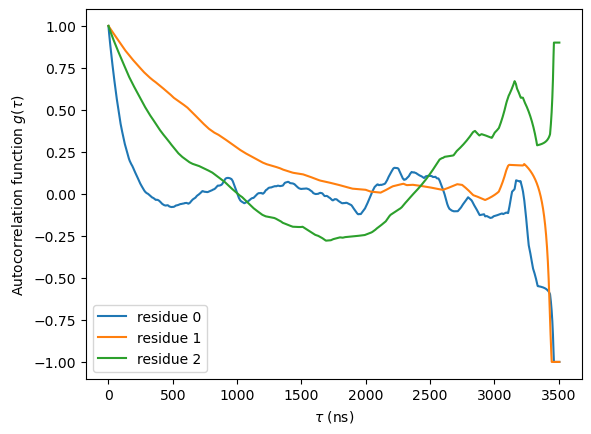

In [10]:
ns_per_step = 0.010
max_tau_res0 = result_res0.shape[0]
max_tau_res1 = result_res1.shape[0]
max_tau_res2 = result_res2.shape[0]

plt.figure()
plt.plot(np.arange(max_tau_res0)*ns_per_step, result_res0, label='residue 0')
plt.plot(np.arange(max_tau_res1)*ns_per_step, result_res1, label='residue 1')
plt.plot(np.arange(max_tau_res2)*ns_per_step, result_res2, label='residue 2')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'Autocorrelation function $g(\tau)$')
plt.legend(loc='best')

plt.savefig('autocoorel_data/autocorrel_res012_2us.pdf')

In [11]:
result_res012 = np.array(result_res012)
result_res012.shape

(3, 350495)

In [12]:
dt_in_ns = 0.010  # 10 ps per step (converted to ns)
print(result_res012.shape)

Nmax = result_res012.shape[1]

for i, res in enumerate(result_res012):  # Ensure i is an index
    tau_c = np.sum(res[0:Nmax]) * dt_in_ns
    print(f"The tau_c for res {i} is {tau_c}")

(3, 350495)
The tau_c for res 0 is -64.62909724876108
The tau_c for res 1 is 692.2486028020229
The tau_c for res 2 is 529.7964570718764


In [16]:
results_trials = []
ntrials = 5
nres = 3

# Load the data
for trial in range(ntrials):
    data = Data.load(f'autocoorel_data/autocorrel_res012_5us_trial{trial}.pkl').array_list
    results_trials.append(data)

# Determine the maximum length among all (trial, res)
max_len = max(len(res_data) for trial_data in results_trials for res_data in trial_data)
print(f"Maximum length of data across all trials and residues: {max_len}")

# Store results with NaN padding
results = np.full((ntrials, nres, max_len), np.nan)
for trial in range(ntrials):
    for res in range(nres):
        arr = results_trials[trial][res]
        results[trial, res, :len(arr)] = arr  # pad with NaN beyond length

# Calculate mean and std along trials, ignoring NaNs
results_mean = np.nanmean(results, axis=0)
results_std = np.nanstd(results, axis=0)
results_std.shape

Maximum length of data across all trials and residues: 303130


(3, 303130)

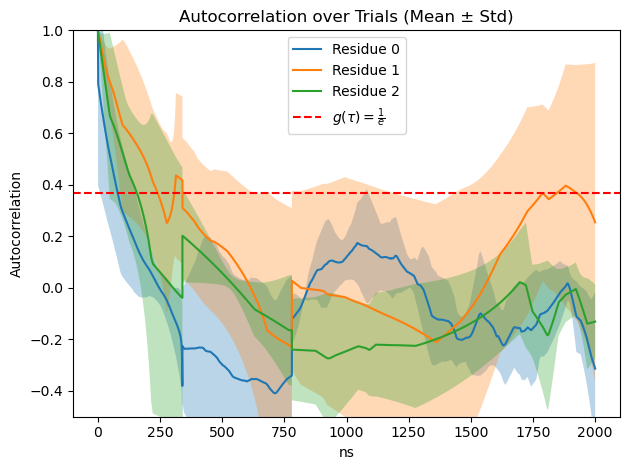

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assume results_mean and results_std have shape (nres, ntau)
nres, ntau = results_mean.shape
time = np.arange(ntau)  # or replace with real time values if available
max_time_plot = 200000

plt.figure()

for res in range(nres):
    mean = results_mean[res][:max_time_plot]
    std = results_std[res][:max_time_plot]

    plt.plot(time[:max_time_plot] * dt_in_ns, mean, label=f'Residue {res}')
    plt.fill_between(time[:max_time_plot] * dt_in_ns, mean - std, mean + std, alpha=0.3)

# Add a red vertical line at 1/e
tau_1e = 1 / np.e  # Compute 1/e
plt.axhline(y=tau_1e, color='r', linestyle='--', label=r'$g(\tau) = \frac{1}{e}$')

plt.xlabel('ns')
plt.ylabel('Autocorrelation')
plt.ylim(-0.5, 1)
plt.title('Autocorrelation over Trials (Mean ± Std)')
plt.legend()
plt.tight_layout()
plt.savefig('autocoorel_data/autocorrel_res012_5us_5trail.pdf')
plt.show()
